In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [86]:
#importing data set

data = pd.read_csv('Data Set 1.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [87]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [88]:
#checking for any missing data.

data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [89]:
for feature in data.columns:
    print(feature, ':', len(data[feature].unique()))

age : 47
anaemia : 2
creatinine_phosphokinase : 208
diabetes : 2
ejection_fraction : 17
high_blood_pressure : 2
platelets : 176
serum_creatinine : 40
serum_sodium : 27
sex : 2
smoking : 2
time : 148
DEATH_EVENT : 2


In [90]:
#classifying features as continuous or discrete.


discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'DEATH_EVENT':
        label = ['DEATH_EVENT']
    elif len(data[feature].unique()) >= 10:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n','Continuous: ', continuous_features)

Discrete:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 Continuous:  ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In [91]:
data[continuous_features[0]]

0      75.0
1      55.0
2      65.0
3      50.0
4      65.0
       ... 
294    62.0
295    55.0
296    45.0
297    45.0
298    50.0
Name: age, Length: 299, dtype: float64

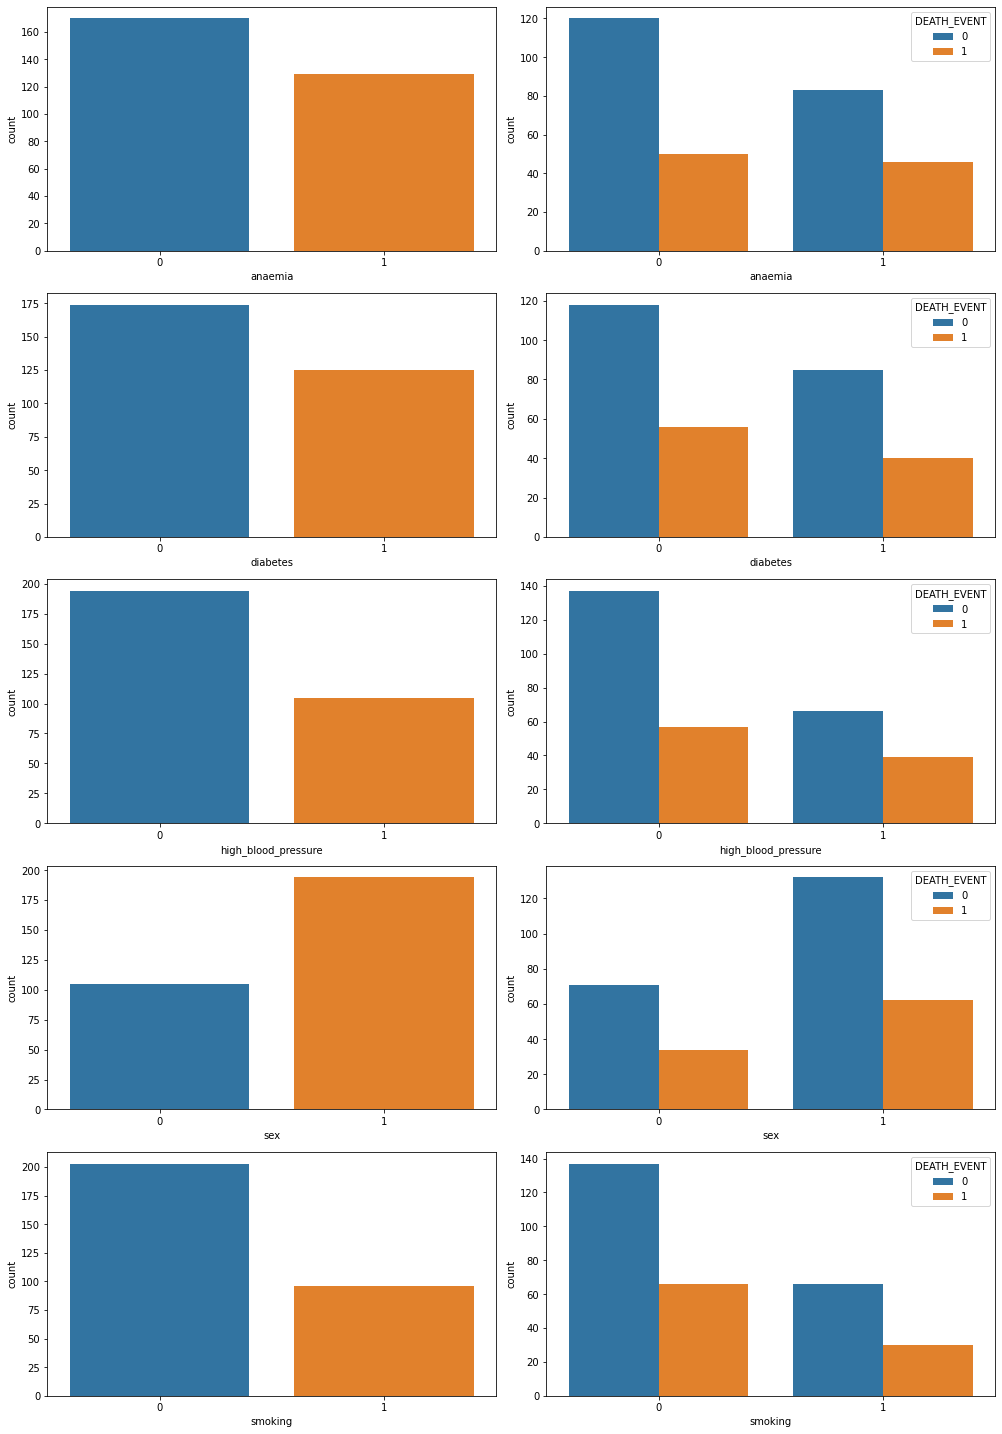

In [92]:
#plots of discrete features

fig, ax = plt.subplots(len(discrete_features), 2, figsize=(14, 20))

for i in range(len(discrete_features)):
    sb.countplot(ax=ax[i, 0], x=discrete_features[i], data=data)
    sb.countplot(ax=ax[i, 1], x=discrete_features[i],
                 hue='DEATH_EVENT', data=data)
fig.tight_layout(pad=1)
plt.show()


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

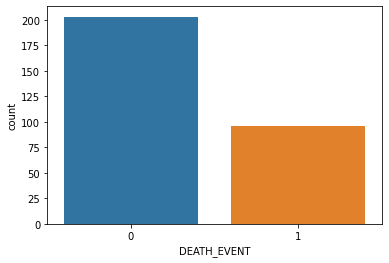

In [93]:
sb.countplot(x='DEATH_EVENT', data=data)


In [94]:
# f, axes = plt.subplots(7, 3, figsize=(24, 24))

# for i in range(len(continuous_features)):
#     sb.boxplot(ax=ax[i, 0], x=continuous_features[i],
#                data=data[continuous_features[i]], orient="h")

#     sb.histplot(ax=ax[i, 1], x=continuous_features[i],
#                 data=data[continuous_features[i]]
#                 )
#     sb.violinplot(ax=ax[i, 2], x=continuous_features[i],
#                   data=data[continuous_features[i]], orient="h")
# fig.tight_layout(pad=1)
# plt.show()





<AxesSubplot:>

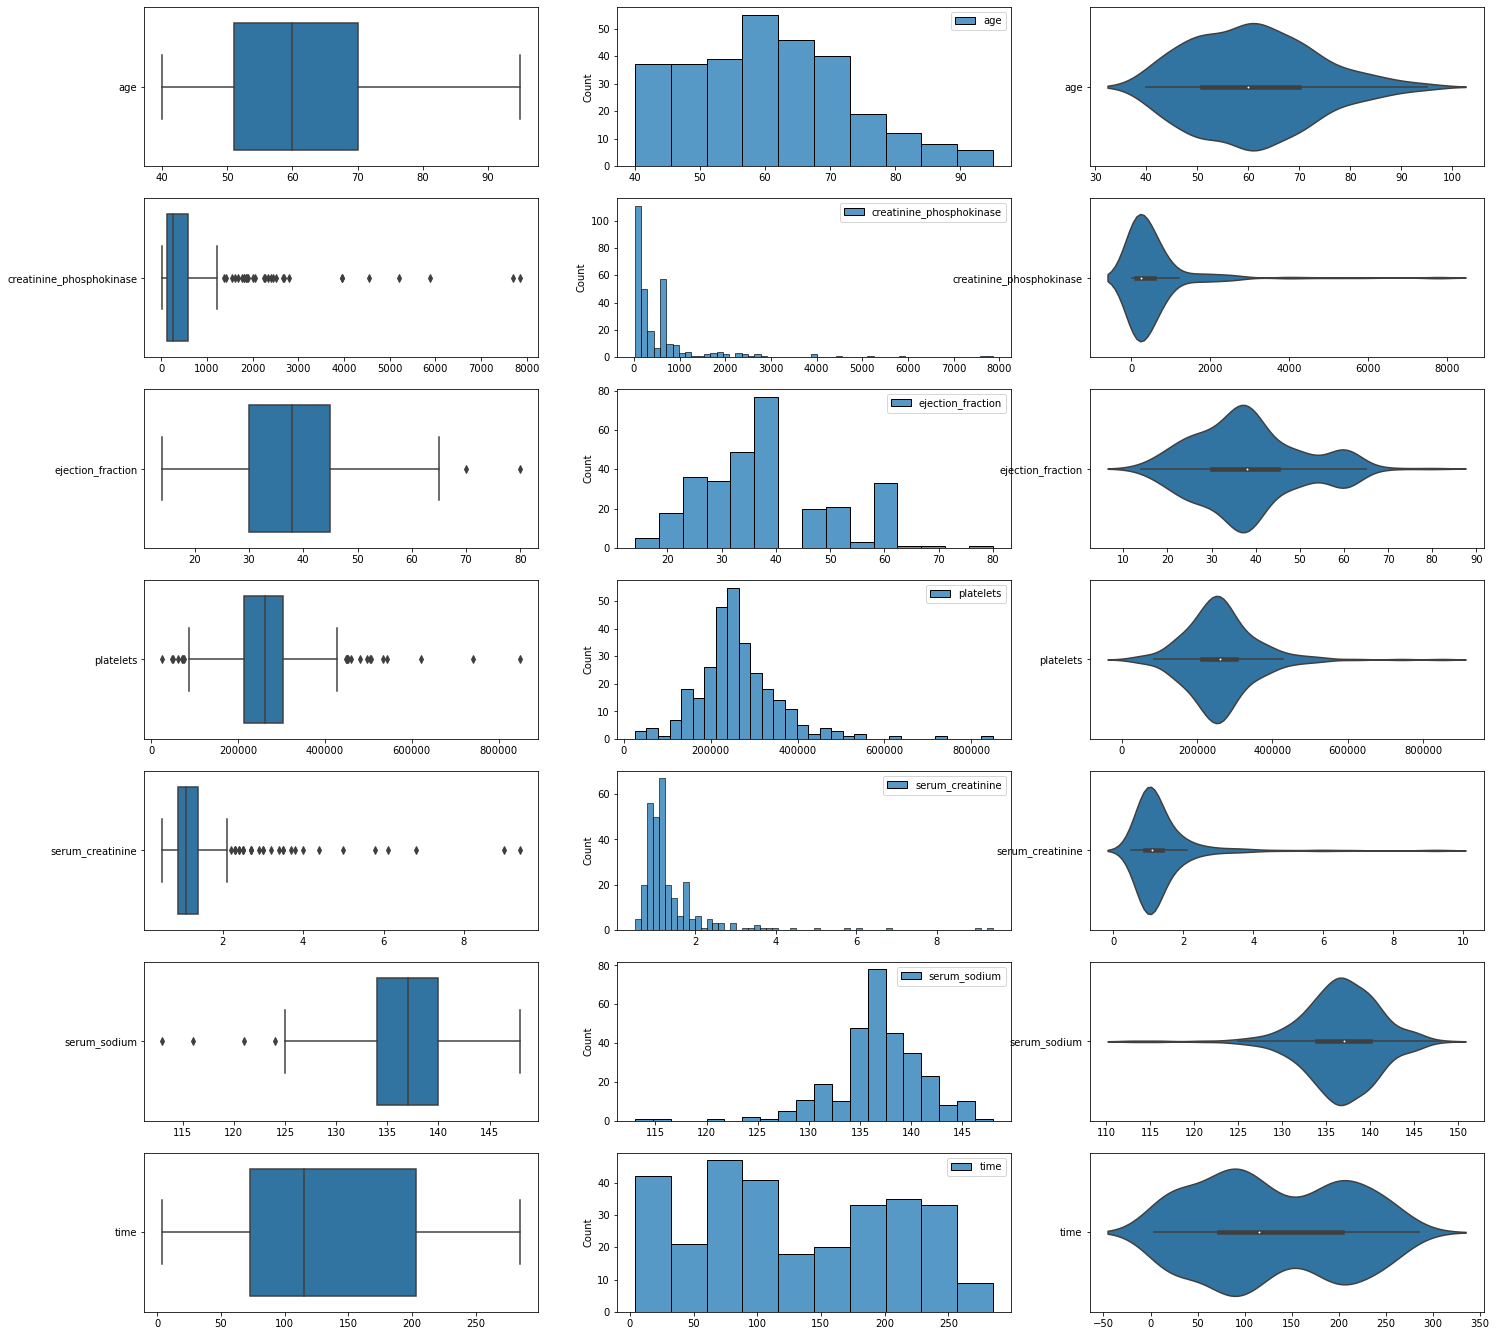

In [95]:
# boxplot, histplot and violinplots for continuous features


age = pd.DataFrame(data['age'])  # Response
creatinine_phosphokinase = pd.DataFrame(
    data['creatinine_phosphokinase'])  # Response
ejection_fraction = pd.DataFrame(data['ejection_fraction'])  # Response
platelets = pd.DataFrame(data['platelets'])  # Response
serum_creatinine = pd.DataFrame(data['serum_creatinine'])  # Response
serum_sodium = pd.DataFrame(data['serum_sodium'])  # Response
time = pd.DataFrame(data['time'])  # Response


f, axes = plt.subplots(7, 3, figsize=(24, 24))
sb.boxplot(data=age, orient="h", ax=axes[0,0])
sb.histplot(data=age, ax=axes[0,1])
sb.violinplot(data=age, orient="h", ax=axes[0,2])

sb.boxplot(data=creatinine_phosphokinase, orient="h", ax=axes[1,0])
sb.histplot(data=creatinine_phosphokinase, ax=axes[1,1])
sb.violinplot(data=creatinine_phosphokinase, orient="h", ax=axes[1,2])

sb.boxplot(data=ejection_fraction, orient="h", ax=axes[2,0])
sb.histplot(data=ejection_fraction, ax=axes[2,1])
sb.violinplot(data=ejection_fraction, orient="h", ax=axes[2,2])

sb.boxplot(data=platelets, orient="h", ax=axes[3,0])
sb.histplot(data=platelets, ax=axes[3,1])
sb.violinplot(data=platelets, orient="h", ax=axes[3,2])

sb.boxplot(data=serum_creatinine, orient="h", ax=axes[4,0])
sb.histplot(data=serum_creatinine, ax=axes[4,1])
sb.violinplot(data=serum_creatinine, orient="h", ax=axes[4,2])

sb.boxplot(data=serum_sodium, orient="h", ax=axes[5,0])
sb.histplot(data=serum_sodium, ax=axes[5,1])
sb.violinplot(data=serum_sodium, orient="h", ax=axes[5,2])

sb.boxplot(data=time, orient="h", ax=axes[6,0])
sb.histplot(data=time, ax=axes[6,1])
sb.violinplot(data=time, orient="h", ax=axes[6,2])


In [96]:
# def detect_outliers(df, features):
#     outlier_indices = []

#     for c in features:
#         # 1st quartile
#         Q1 = np.percentile(df[c], 25)
#         # 3st quartile
#         Q3 = np.percentile(df[c], 75)
#         # IQR
#         IQR = Q3 - Q1
#         # Outlier Step
#         outlier_step = IQR * 1.5
#         # detect outlier and their indeces
#         outlier_list_col = df[(df[c] < Q1 - outlier_step)
#                               | (df[c] > Q3 + outlier_step)].index
#         # store indeces
#         outlier_indices.extend(outlier_list_col)

#     outlier_indices = Counter(outlier_indices)
#     multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)

#     return multiple_outliers


In [97]:
# data.loc[detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"])]

In [98]:
# data = data.drop(detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]),axis = 0).reset_index(drop=True)

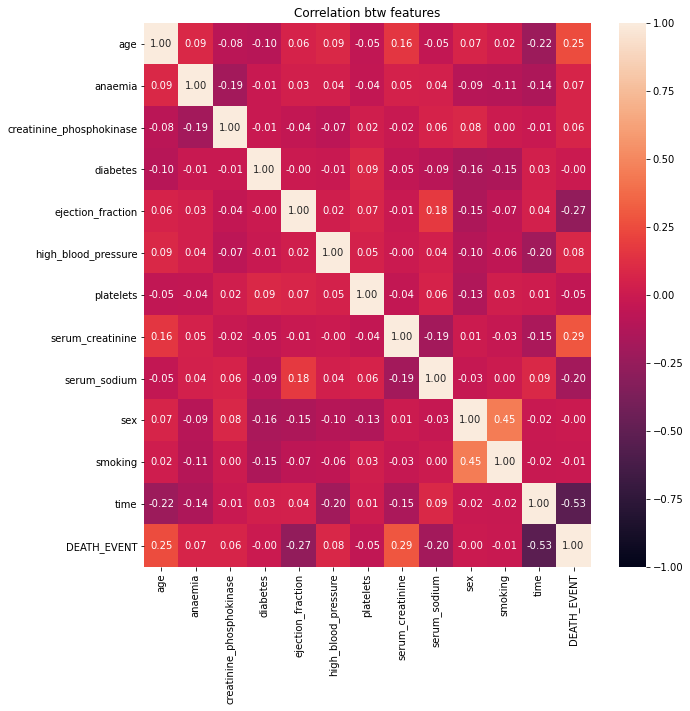

In [99]:
#plotting correlation plot.

plt.figure(figsize=(10, 10))
sb.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation btw features")
plt.show()

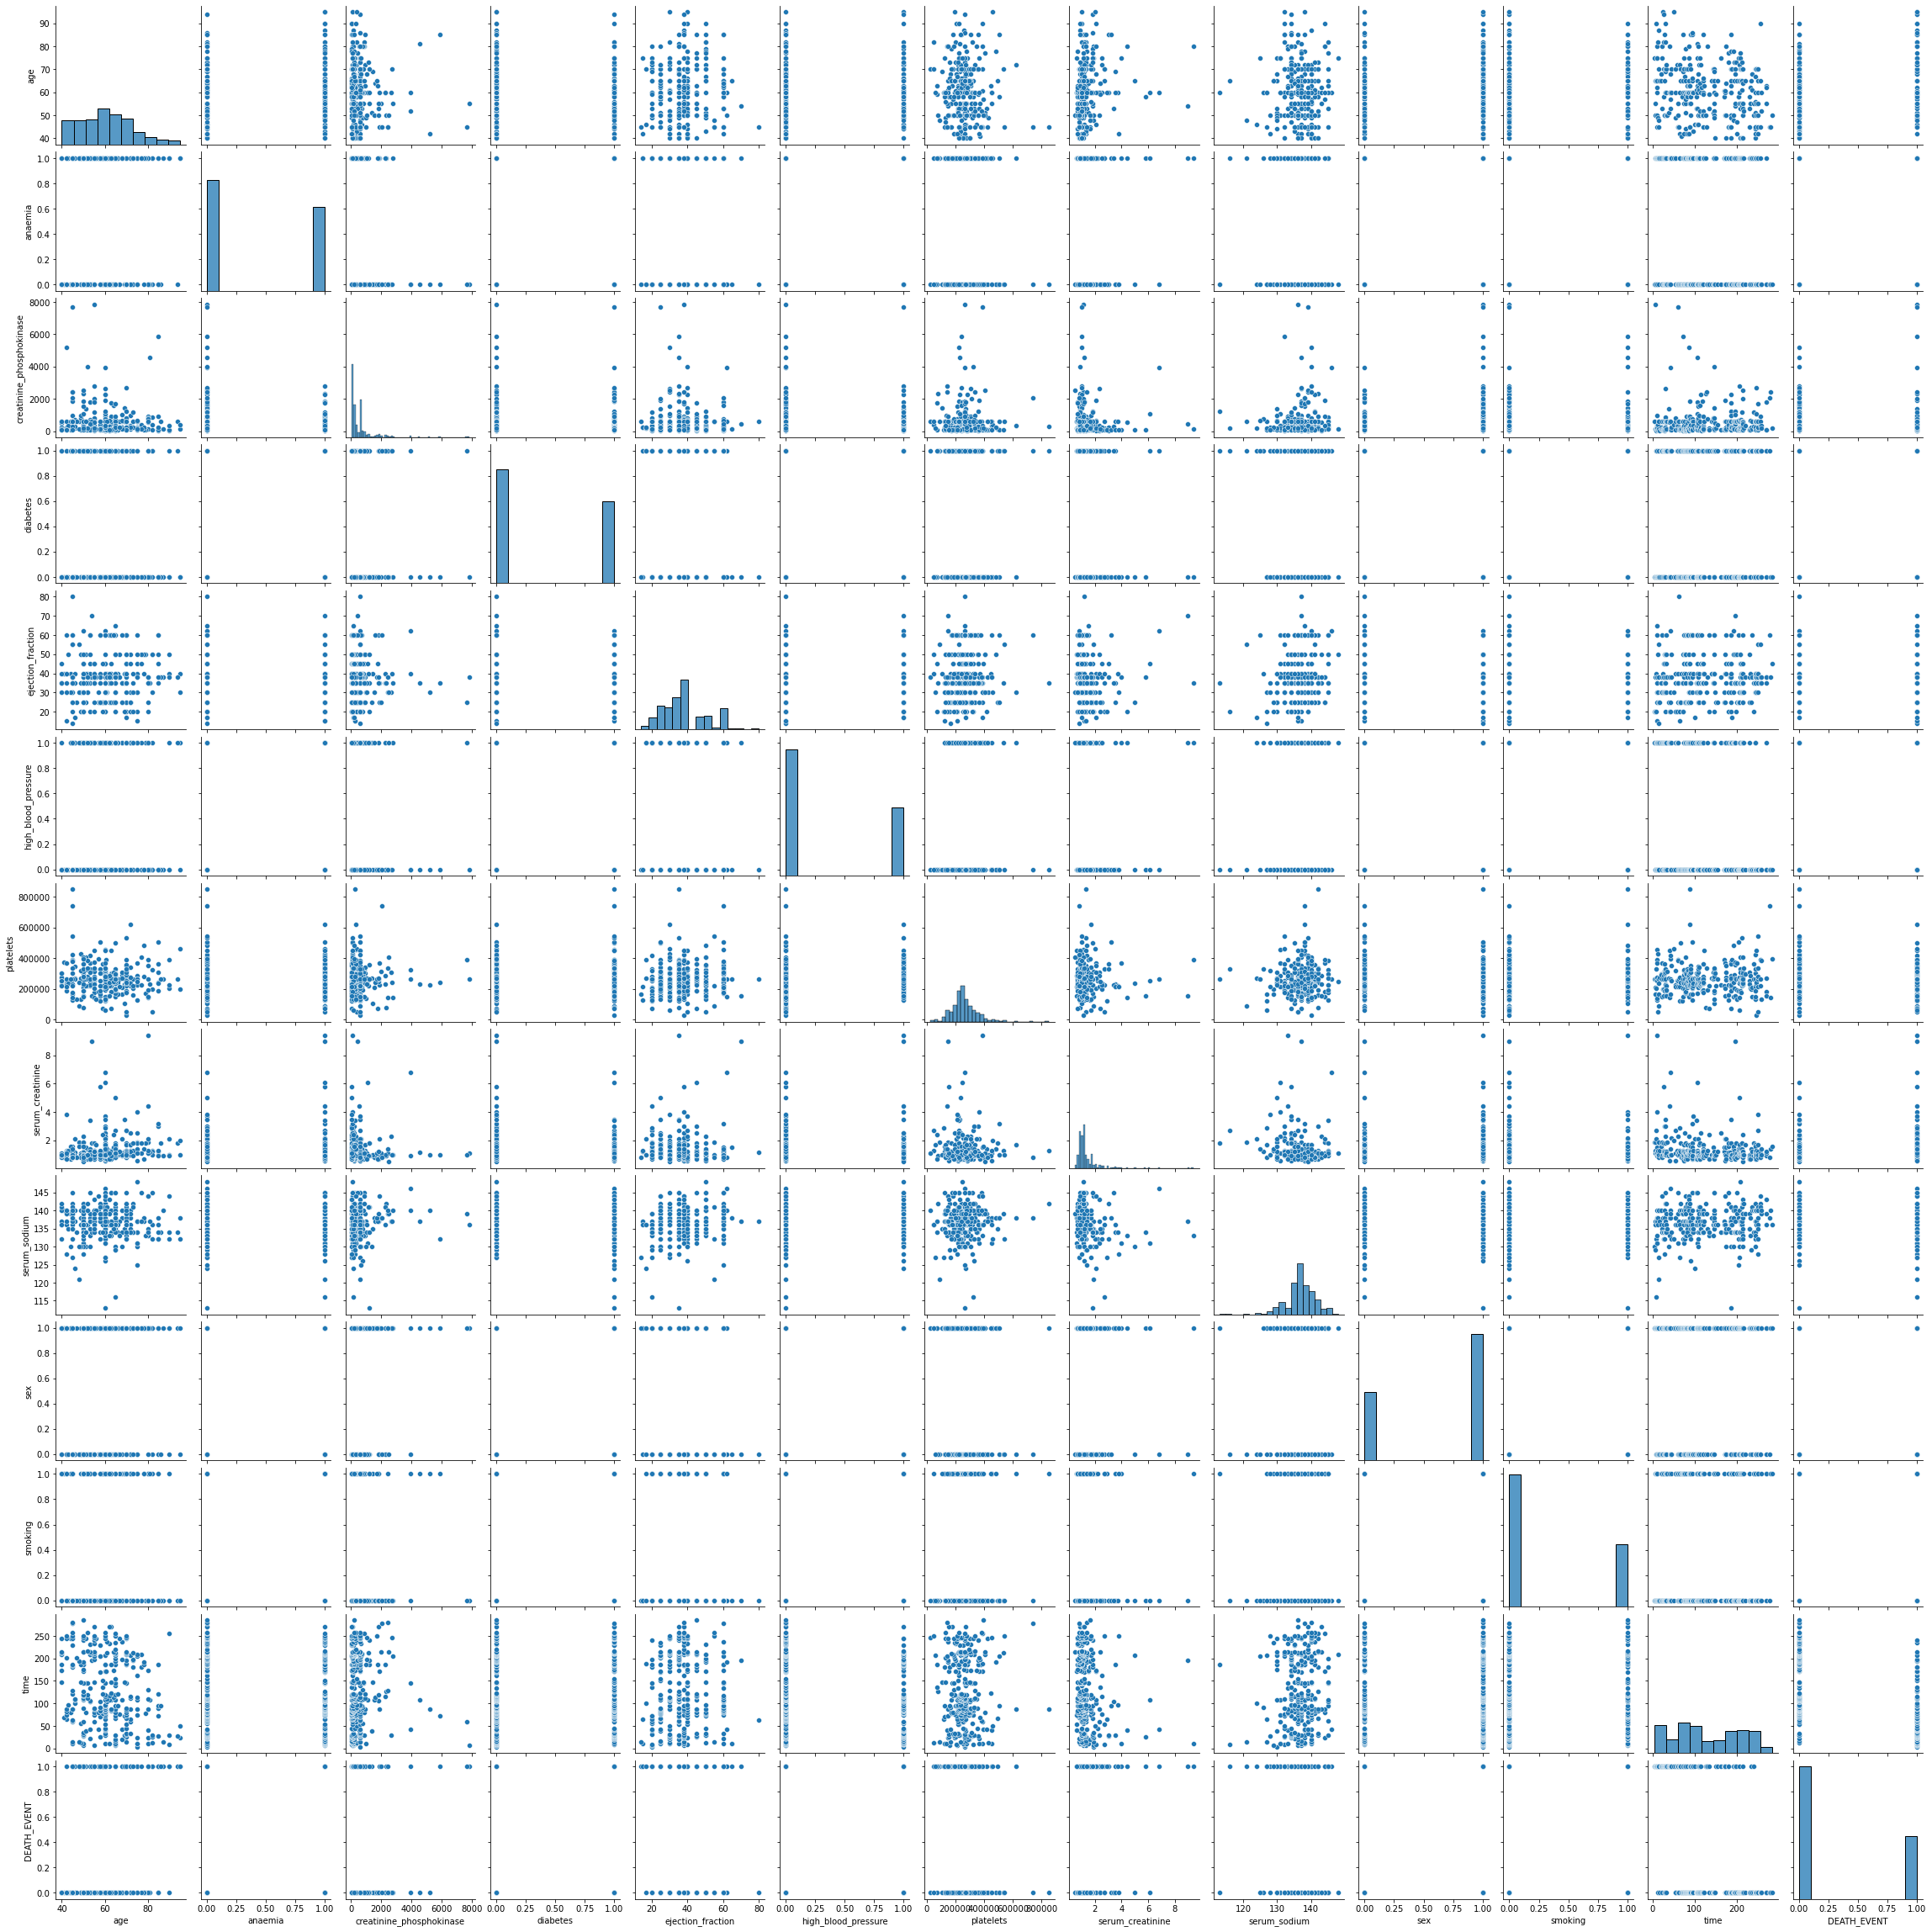

In [100]:
#pair plot

sb.pairplot(data=data)

We can see most feautures are not correlated with Death Event. However, we can see a few features have a slight -correlation and we can factor them out.

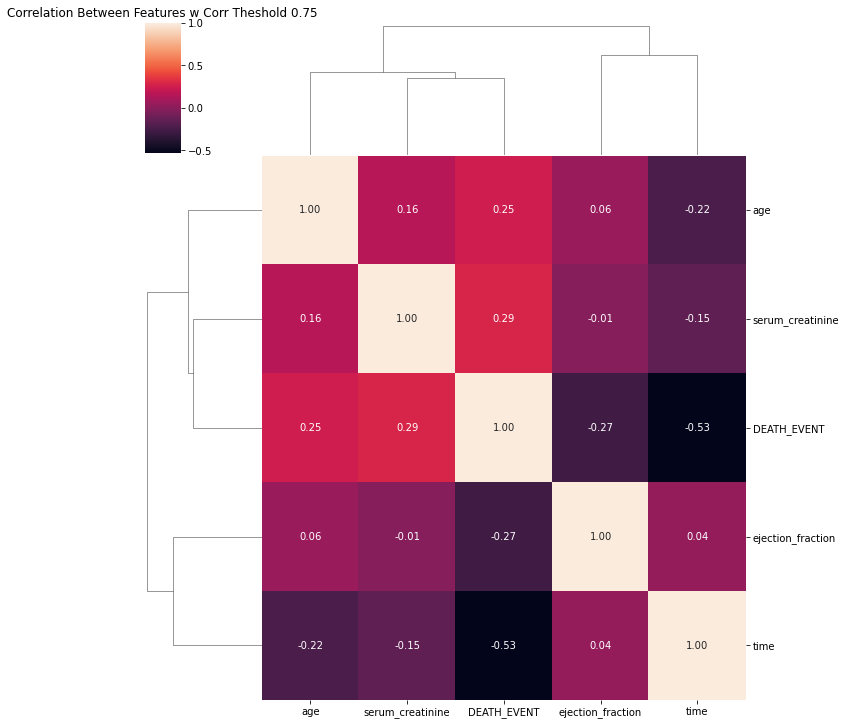

In [101]:
#filtering out weakly correlated features

threshold = 0.2
filtre = np.abs(data.corr()["DEATH_EVENT"]) > threshold
corr_features = data.corr().columns[filtre].tolist()
sb.clustermap(data[corr_features].corr(), annot=True, fmt=".2f")
plt.title("Correlation Between Features w Corr Theshold 0.75")
plt.show()

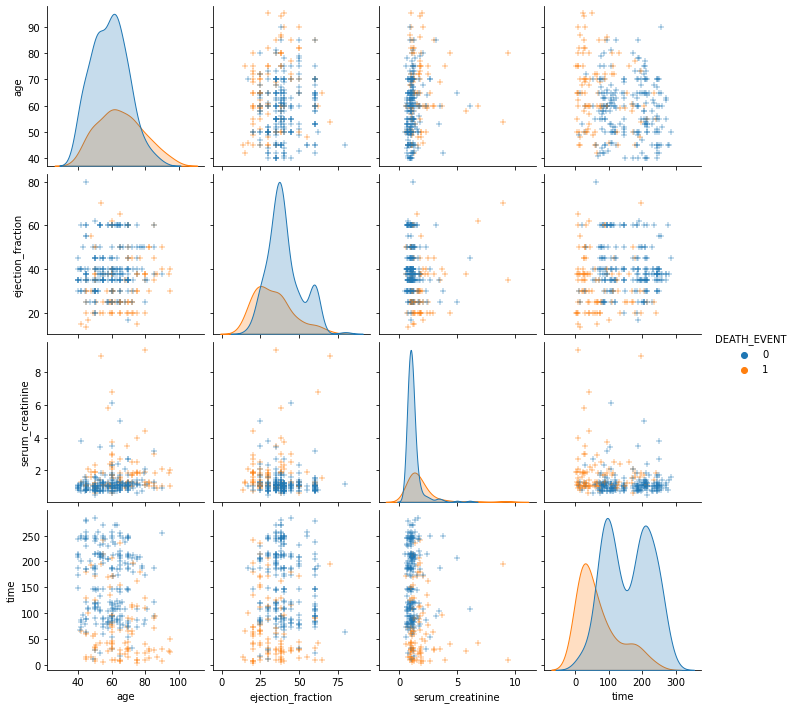

In [102]:
#pair plot

sb.pairplot(data[corr_features], diag_kind="kde",
             markers="+", hue="DEATH_EVENT")
plt.show()

First Using Classification Models namely the correlation plot and the trained decision tree we can try to predict which factors have the most influence on the Death Rate. The data set in randomly split into test data (25% of the whole data) and train data. The train data can be used to create a classification model and tested with the test data we have. 

### Multi-variate Decision Tree based on numerical variables

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 92.41071428571429 %

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 82.66666666666667 %



<AxesSubplot:>

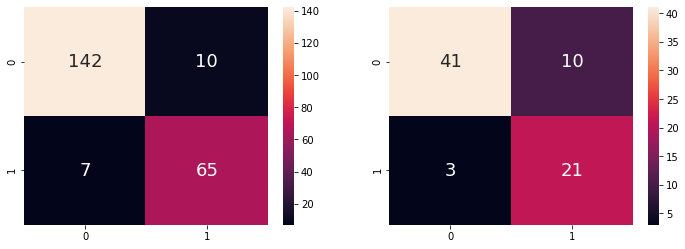

In [148]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
predictors = ["creatinine_phosphokinase", "ejection_fraction", "serum_creatinine", "platelets", "serum_sodium", "time", "age"]

y = pd.DataFrame(data['DEATH_EVENT'])
X = pd.DataFrame(data[predictors]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train)*100, "%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test)*100, "%")
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

As seen here, the Classification accuracy of this model 88% for the train dataset and 82% with the test dataset. We can then go on to determine which factors have the greatest impact via the decision tree. Since we used a random sample of data the classification accuracy changes at every run but averages around 88% for train and 82% for test. As the max_depth was increased the classification accuracy in the train data increased however the same cannot be said about the test data. The classification accuracy in the test data in some regions decreased with the increase in max_depth. 

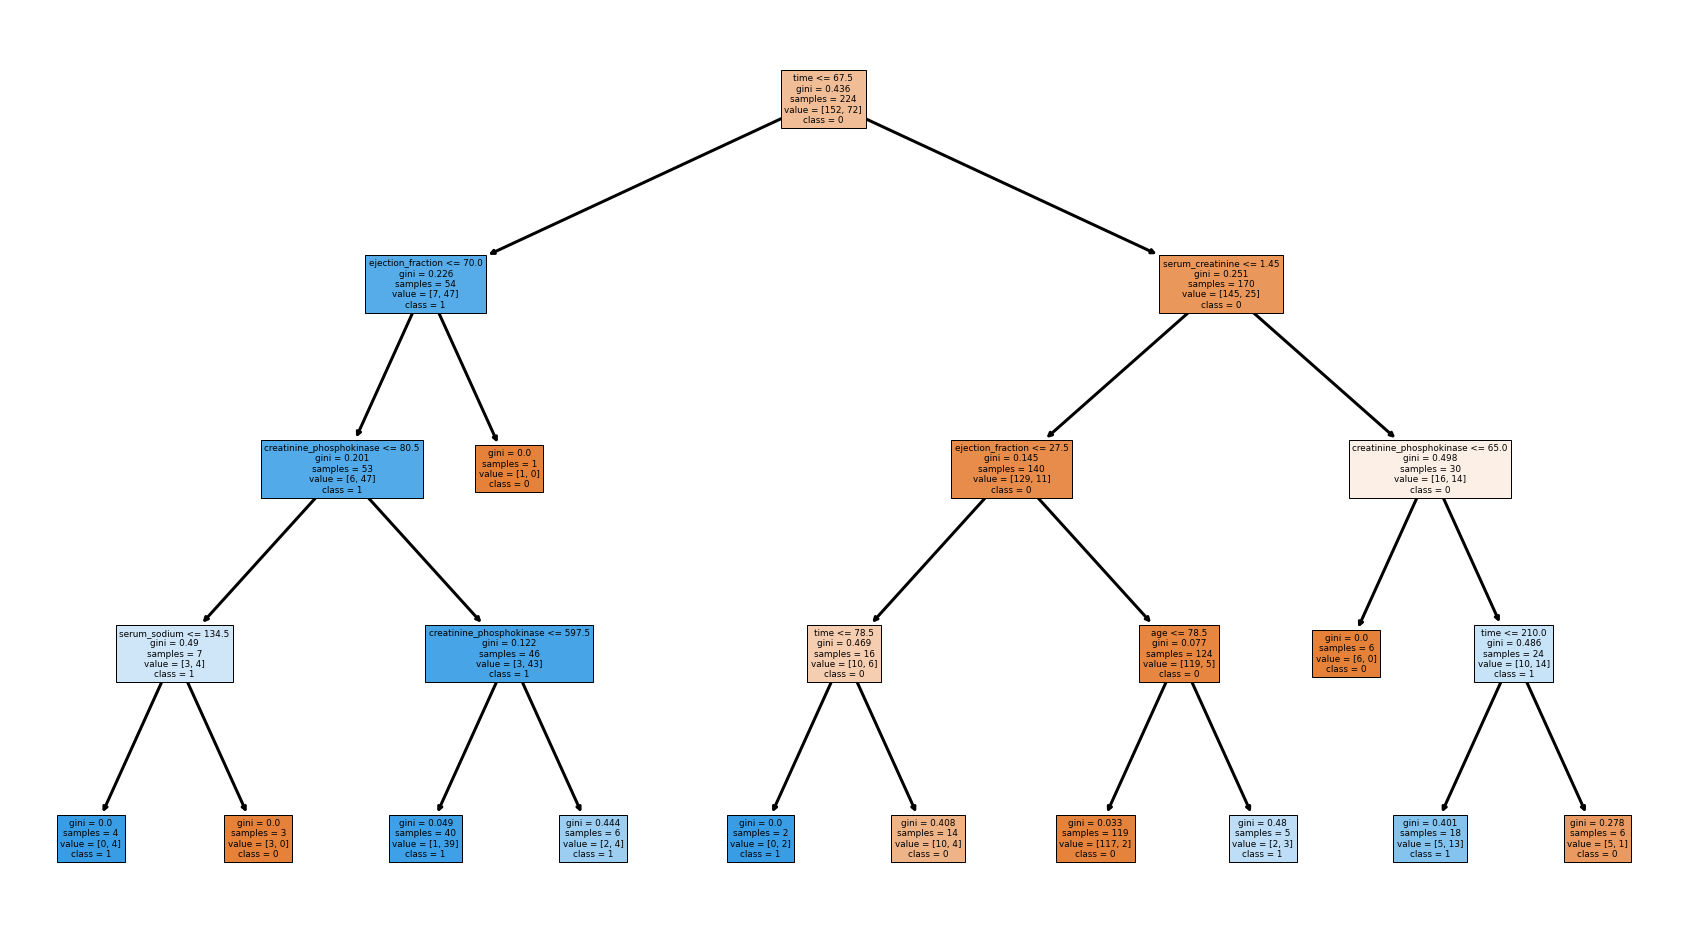

In [149]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(30, 17))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

### Decision tree based on categorical variables 

In [140]:
CatData = pd.DataFrame(data[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']])
CatData.info()
for col in CatData:
    CatData[col] = CatData[col].astype('category')#Modifying the category
CatData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   anaemia              299 non-null    int64
 1   diabetes             299 non-null    int64
 2   high_blood_pressure  299 non-null    int64
 3   sex                  299 non-null    int64
 4   smoking              299 non-null    int64
 5   DEATH_EVENT          299 non-null    int64
dtypes: int64(6)
memory usage: 14.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   anaemia              299 non-null    category
 1   diabetes             299 non-null    category
 2   high_blood_pressure  299 non-null    category
 3   sex                  299 non-null    category
 4   smoking              299 non-null    category
 5   DEATH_E

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 68.30357142857143 %

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 68.0 %



<AxesSubplot:>

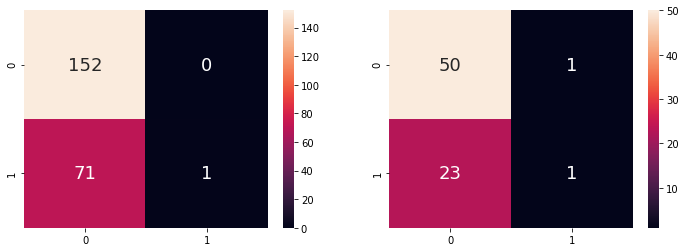

In [144]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
y = pd.DataFrame(data['DEATH_EVENT'])
X = pd.DataFrame(CatData[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train)*100, "%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test)*100, "%")
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

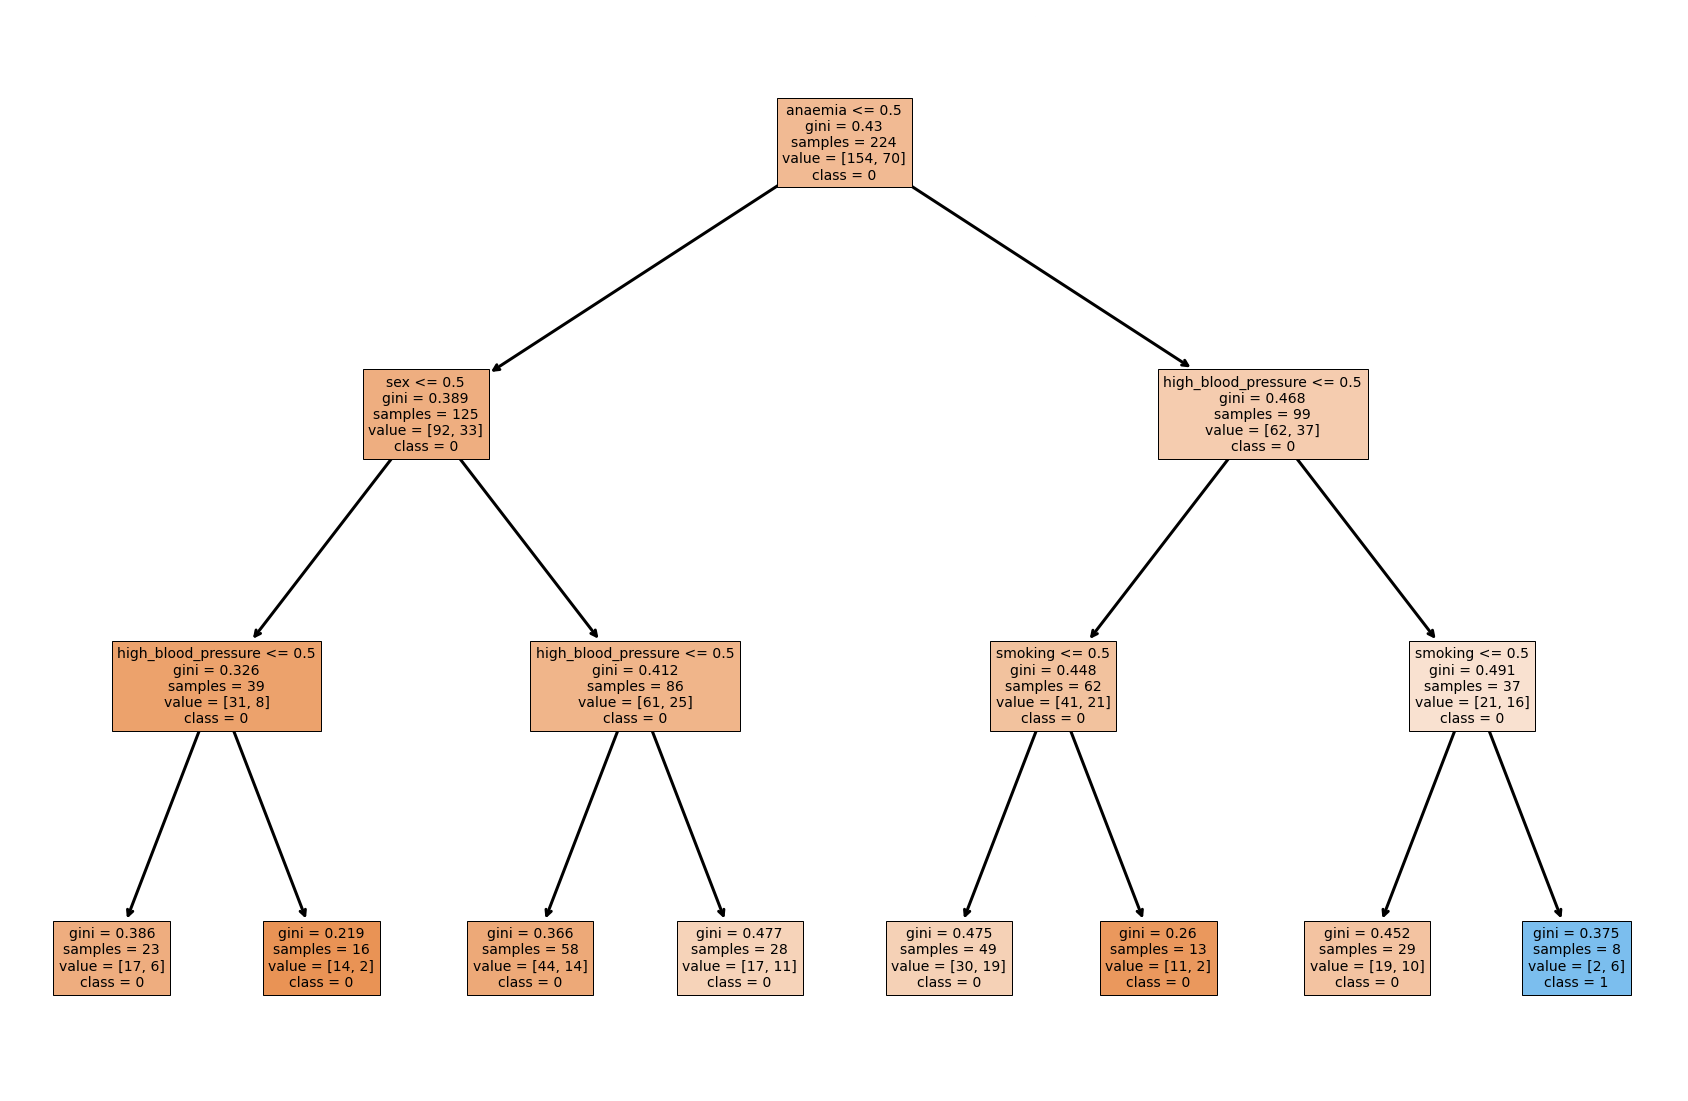

In [143]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(30, 20))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

The factors that have the greatest impact can be narrowed down to time, serum_creatinine, serum_sodium and ejection fraction. 

We have filtered out the above features which have the highest correlation with Death Event. As we can see, 4 -features have the highest correlation-age, ejection fraction, serum_creatnine, time. 

In [108]:
#using Lasso to filter out relevant features

feature_model = SelectFromModel(Lasso(alpha=0.05, random_state=0))
feature_model.fit(data.drop(['DEATH_EVENT'], axis=1), data['DEATH_EVENT'])

SelectFromModel(estimator=Lasso(alpha=0.05, random_state=0))

In [109]:
#printing out weakly correlated features

mask = feature_model.get_support() 
for i in range(len(mask)):
    if not mask[i]:
        print(data.drop(['DEATH_EVENT'], axis=1).columns[i])

anaemia
diabetes
high_blood_pressure
platelets
sex
smoking


### Observations
- Based on EDA and Feature Selection, features such as **anaemia, diabetes, age, sex, smoking** are less contributing.
- Features to be considered are, **platelets, time, serum_creatnine, ejection_fraction.**

### Model Building without Sampling using logistical regression and random forest classifiers

In [110]:
X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(239, 12) (60, 12)


The accuracy of Logistic Regression is :  78.33333333333333 %
              precision    recall  f1-score   support

           0       0.75      0.97      0.85        37
           1       0.92      0.48      0.63        23

    accuracy                           0.78        60
   macro avg       0.83      0.73      0.74        60
weighted avg       0.81      0.78      0.76        60



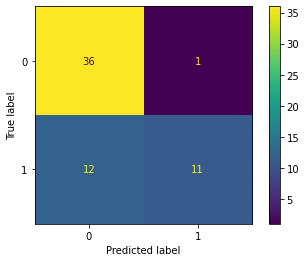

In [111]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Logistic Regression is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


The accuracy of Random Forest is :  85.0 %
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.94      0.65      0.77        23

    accuracy                           0.85        60
   macro avg       0.88      0.81      0.83        60
weighted avg       0.86      0.85      0.84        60



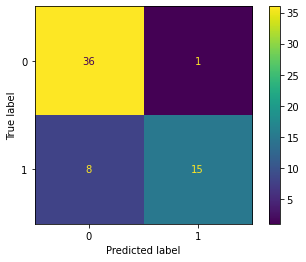

In [112]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Random Forest is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


Considering all the features, the accuracy with Logistic Regression is 78% and Random Forest is 85%

### Trying with different sets of features based on the observations.


In [113]:
X = data[['creatinine_phosphokinase', 'ejection_fraction',
          'platelets', 'serum_creatinine', 'time']]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(239, 5) (60, 5)


The accuracy of Logistic Regression is :  86.66666666666667 %
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        43
           1       0.76      0.76      0.76        17

    accuracy                           0.87        60
   macro avg       0.84      0.84      0.84        60
weighted avg       0.87      0.87      0.87        60



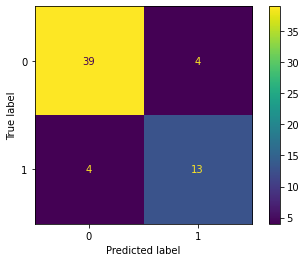

In [114]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Logistic Regression is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


The accuracy of Random Forest is :  91.66666666666666 %
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        43
           1       0.93      0.76      0.84        17

    accuracy                           0.92        60
   macro avg       0.92      0.87      0.89        60
weighted avg       0.92      0.92      0.91        60



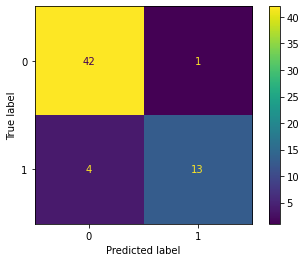

In [115]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Random Forest is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


### Conclusion:
Ifa few features were eliminated and considering creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, time,


The accuracies are:
* Logistic Regression --> 87%
* Random Forest -->91%


In [116]:
X = data[['ejection_fraction', 'serum_creatinine', 'time']]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(239, 3) (60, 3)


The accuracy of Logistic Regression is :  90.0 %
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.87      0.76      0.81        17

    accuracy                           0.90        60
   macro avg       0.89      0.86      0.87        60
weighted avg       0.90      0.90      0.90        60



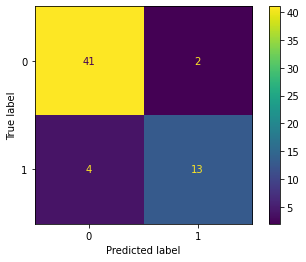

In [117]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Logistic Regression is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


The accuracy of Random Forest is :  88.33333333333333 %
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        43
           1       0.86      0.71      0.77        17

    accuracy                           0.88        60
   macro avg       0.87      0.83      0.85        60
weighted avg       0.88      0.88      0.88        60



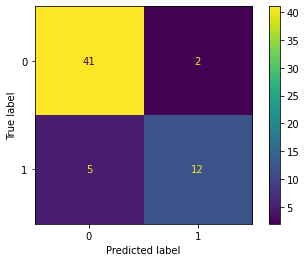

In [118]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Random Forest is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


### Conclusion:
If we consider the ones which are highly correlated to the output label,
features = {ejection_fraction, serum_creatinine, time}


* Logistic Regression --> 90%
* Random Forest --> 90%

### Model Building with SMOTE using logistical regression and random forest classifiers

In [119]:

X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

oversample = SMOTE(sampling_strategy='minority')
X_sampled, y_sampled = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(324, 12) (82, 12)


The accuracy of Logistic Regression is :  89.02439024390245 %
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        35
           1       0.87      0.96      0.91        47

    accuracy                           0.89        82
   macro avg       0.90      0.88      0.89        82
weighted avg       0.89      0.89      0.89        82



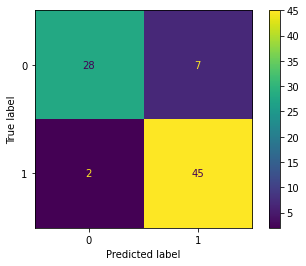

In [120]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Logistic Regression is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


The accuracy of Random Forest is :  92.6829268292683 %
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       0.90      0.98      0.94        47

    accuracy                           0.93        82
   macro avg       0.93      0.92      0.92        82
weighted avg       0.93      0.93      0.93        82



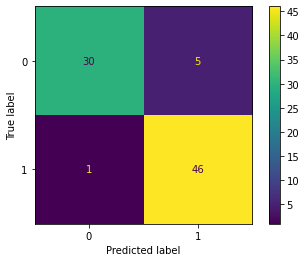

In [121]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Random Forest is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


#### Trying with different sets of features based on the observations.

In [122]:
X = data[['ejection_fraction', 'serum_creatinine','time']]
y = data['DEATH_EVENT']

oversample = SMOTE(sampling_strategy='minority')
X_sampled, y_sampled = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(324, 3) (82, 3)


The accuracy of Logistic Regression is :  81.70731707317073 %
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        39
           1       0.80      0.86      0.83        43

    accuracy                           0.82        82
   macro avg       0.82      0.81      0.82        82
weighted avg       0.82      0.82      0.82        82



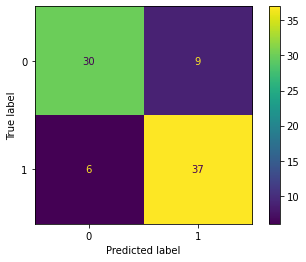

In [123]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Logistic Regression is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


The accuracy of Random Forest is :  87.8048780487805 %
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        39
           1       0.87      0.91      0.89        43

    accuracy                           0.88        82
   macro avg       0.88      0.88      0.88        82
weighted avg       0.88      0.88      0.88        82



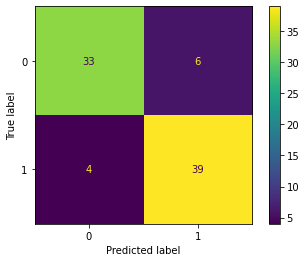

In [124]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf = plot_confusion_matrix(model, X_test, y_test)
print("The accuracy of Random Forest is : ",
      accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))


**features = {ejection_fraction, serum_creatinine, time}**

The accuracies over here are slightly corrected as it is tested on sampled data.

* Logistic Regression --> 90%
* Random Forest --> 90%